# Установка библиотек

In [699]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [700]:
# https://pypi.org/project/pgeocode/
# pip install pgeocode

In [701]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


# Импорт библиотек

In [775]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgeocode as geo
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import phik


import matplotlib
import geopandas as gpd

rs = 123

In [835]:
try:
    df = pd.read_csv('autos.csv')
    df = pd.read_csv('autos_with_geo.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Сразу удалим дубликаты

In [836]:
print(f'Было {df.duplicated().sum()} полных дубликатов')
df = df.drop_duplicates()
print(f'Осталось {df.duplicated().sum()} полных дубликатов')

Было 4 полных дубликатов
Осталось 0 полных дубликатов


Взглянем на данные

In [837]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,PlaceName,StateName,Latitude,Longitude
295270,2016-04-02 16:52:32,6660,small,2011,manual,69,ka,40000,3,petrol,ford,no,2016-04-02 00:00:00,0,53919,2016-04-06 16:15:54,Weilerswist,Nordrhein-Westfalen,50.7529,6.8458
20931,2016-03-08 18:39:49,300,small,1998,manual,45,polo,150000,0,petrol,volkswagen,yes,2016-03-08 00:00:00,0,32602,2016-03-09 09:46:45,Vlotho,Nordrhein-Westfalen,52.1388,8.7806
54475,2016-03-09 20:50:10,7900,wagon,2006,auto,163,5er,150000,12,gasoline,bmw,no,2016-03-09 00:00:00,0,84152,2016-03-11 05:44:24,Mengkofen,Bayern,48.7189,12.4405


Переименуем названия колонок

In [838]:
df.columns = ['_'.join(words).lower() for words in [re.findall(r'([A-Z]{1}[a-z]+)', el) for el in df.columns]]

Напишем функцию, выводящую всю статистическую информацию по датасету

In [780]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [781]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
date_crawled,354365,0,object,,,,,,,,
price,354365,0,int64,354365.0,4416.67983,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,316875,37490,object,,,,,,,,
registration_year,354365,0,int64,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,334532,19833,object,,,,,,,,
power,354365,0,int64,354365.0,110.093816,189.85133,0.0,69.0,105.0,143.0,20000.0
model,334660,19705,object,,,,,,,,
kilometer,354365,0,int64,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354365,0,int64,354365.0,5.71465,3.726432,0.0,3.0,6.0,9.0,12.0
fuel_type,321470,32895,object,,,,,,,,


Наблюдения следующие
- В пяти колонках есть пропуски
- Типы данных неоптимальны

# EDA

По порядку пройдем по всем признакам

## price

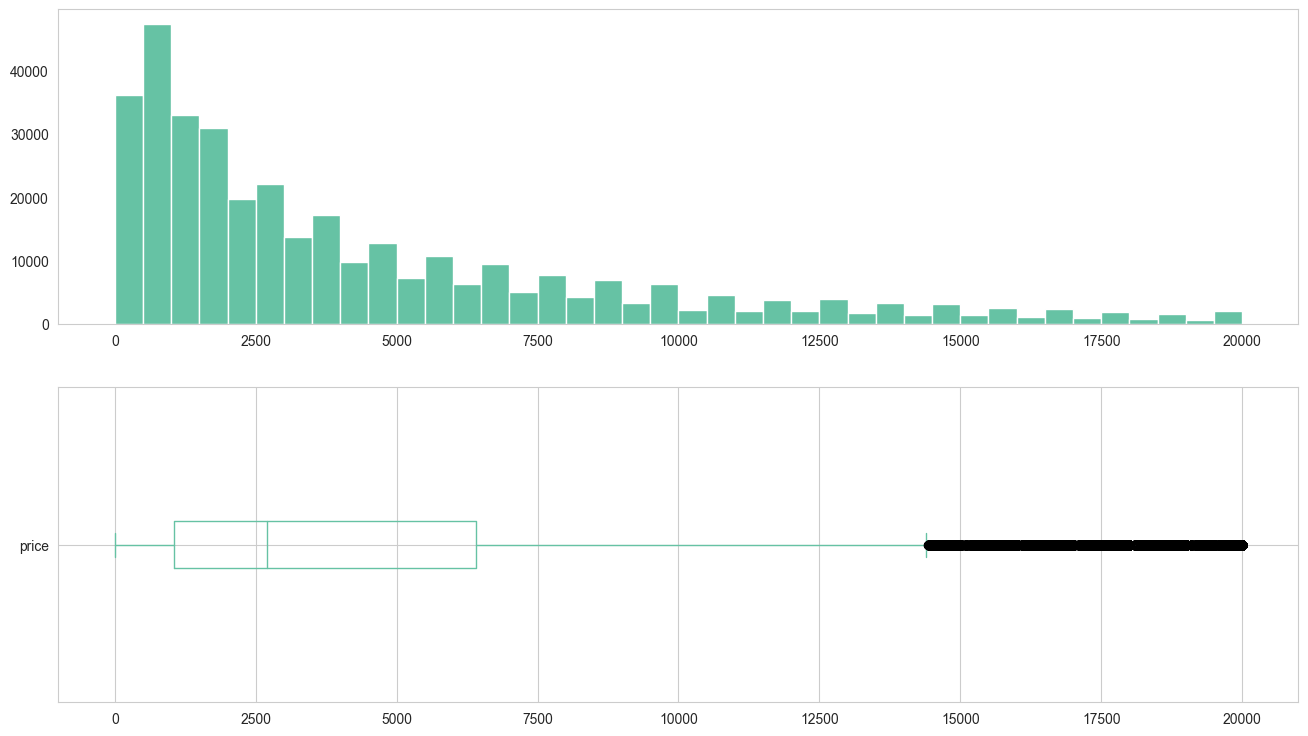

In [782]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))
df['price'].hist(grid=False, bins=40, color='#66c2a4', ax=ax1);
df['price'].plot.box(grid=True, vert=False, color='#66c2a4', ax=ax2);

Для цен характерно распределение Пуассона, оставим только объявления дороже 300 евро

In [783]:
df = df[df['price']>300]

## number_of_pictures

In [884]:
try:
    print(f'в датасете {df["number_of_pictures"].unique()[0]} уникальных значений в поле с числом фотографий')
    df = df.drop('number_of_pictures', axis=1)
except:
    print('Столбец уже удален')

в датасете 0 уникальных значений в поле с числом фотографий


Фотографий нет ни у кого

In [760]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,latitude,longitude,population
0,480,other,1993,manual,0,volkswagen volkswagen golf,150000,petrol,volkswagen,True,48.800050,9.174450,NaN
1,18300,coupe,2011,manual,190,audi audi other,125000,gasoline,audi,True,49.207100,7.591100,43582.0
2,9800,suv,2004,auto,163,jeep jeep grand,125000,gasoline,jeep,True,49.437100,11.119400,515543.0
3,1500,small,2001,manual,75,volkswagen volkswagen golf,150000,petrol,volkswagen,False,49.568000,10.885600,23319.0
4,3600,small,2008,manual,69,skoda skoda fabia,90000,gasoline,skoda,False,50.192400,8.675300,650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,opel opel zafira,150000,petrol,opel,False,53.475527,7.351636,NaN
354365,2200,other,2005,NaN,0,sonstige_autos sonstige_autos other,20000,NaN,sonstige_autos,True,52.606900,11.858700,37722.0
354366,1199,convertible,2000,auto,101,smart smart fortwo,125000,petrol,smart,False,53.126700,8.238400,159218.0
354367,9200,bus,1996,manual,102,volkswagen volkswagen transporter,150000,gasoline,volkswagen,False,47.717700,10.298900,NaN


## postal_code

У нас есть колонка с почтовым индексом. Возможно, по ней удастся установить географию объявлений. При помощи библиотеки pgeocode добавим в датасет название населенного пункта и области, а также долготу и широту

In [711]:
nomi = geo.Nominatim('DE')
def postal_coder(row):
    res = nomi.query_postal_code(row)
    return res['place_name'], res['state_name'], res['latitude'], res['longitude']

In [712]:
%%time
df['postal_code'].head(10).apply(postal_coder)

CPU times: total: 46.9 ms
Wall time: 47 ms


0     (Stuttgart, Stuttgart Zuffenhausen, Baden-Würt...
1         (Pirmasens, Rheinland-Pfalz, 49.2071, 7.5911)
2                  (Nürnberg, Bayern, 49.4371, 11.1194)
3             (Herzogenaurach, Bayern, 49.568, 10.8856)
4          (Frankfurt am Main, Hessen, 50.1924, 8.6753)
5      (Versmold, Nordrhein-Westfalen, 52.0401, 8.1527)
6       (Mutterstadt, Rheinland-Pfalz, 49.4414, 8.3561)
8                  (Bernried, Bayern, 48.9167, 12.8833)
9             (Cuxhaven, Niedersachsen, 53.8584, 8.709)
10              (Burgkunstadt, Bayern, 50.1409, 11.252)
Name: postal_code, dtype: object

Функция работает довольно долго, поэтому мы воспроизвели датасет из сохраненного заранее файла

In [713]:
# %%time
# df['PlaceName'], df['StateName'], df['Latitude'], df['Longitude'], = zip(*df['PostalCode'].apply(postal_coder))

In [714]:
print(f'Геоданные не найдены для {df["place_name"].isna().sum()} записей')

Геоданные не найдены для 15984 записей


Пока не убедимся, что признаки полезны, не будем удалять эти записи

In [715]:
%%time
top_cities = pd.read_csv('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/csv?lang=en&timezone=Europe%2FMinsk&use_labels=true&delimiter=%3B', sep=';')

top_cities = top_cities[top_cities['LABEL EN']=='Germany'].sort_values('Population', ascending=False)[['Name', 'Coordinates', 'Population']]

top_cities['latitude'] = top_cities['Coordinates'].apply(lambda x: x.split(',')[0])
top_cities['longitude'] = top_cities['Coordinates'].apply(lambda x: x.split(',')[1])
top_cities.drop('Coordinates', axis=1, inplace=True)

top_cities['longitude'] = top_cities['longitude'].astype('float')
top_cities['latitude'] = top_cities['latitude'].astype('float')

# Два города накладываются друг на друга
top_cities = top_cities[top_cities['Name']!='Großzschocher']

CPU times: total: 969 ms
Wall time: 55.6 s


Посмотрим, сколько городов дублируется

In [716]:
print(f'{top_cities.shape[0]-top_cities["Name"].nunique()} городов повторяется. Надо удалить')

352 городов повторяется. Надо удалить


In [717]:
top_cities = top_cities.drop_duplicates('Name')

In [718]:
top_cities

,Name,Population,latitude,longitude
10924,Berlin,3426354,52.52437,13.41053
114885,Hamburg,1845229,53.55073,9.99302
124321,Munich,1260391,48.13743,11.57549
11720,Köln,963395,50.93333,6.95000
18203,Frankfurt am Main,650000,50.11552,8.68417
...,...,...,...,...
27463,Falkenfels,1001,49.00415,12.59480
78533,Pfeffelbach,1001,49.53948,7.32768
93507,Burg Unter-Falkenstein,0,47.70440,12.10466
61814,Haselbachtal,0,51.23570,14.02576


In [719]:
tmp = df.groupby('postal_code').agg(longitude=('longitude', 'first'),
                                         latitude=('latitude', 'first'),
                                         count=('place_name', 'count'),
                                         median=('price', 'median')).query('count>20')
tmp

,longitude,latitude,count,median
postal_code,,,,
10115,13.384600,52.532300,809,10500.0
10117,13.387200,52.517000,64,4625.0
10119,13.405300,52.530500,47,2850.0
10178,13.409600,52.521300,52,4000.0
10179,13.416400,52.512200,41,3500.0
...,...,...,...,...
99894,10.591633,50.852300,32,3515.0
99897,10.615700,50.792500,21,2000.0
99947,10.638018,51.157027,65,3000.0


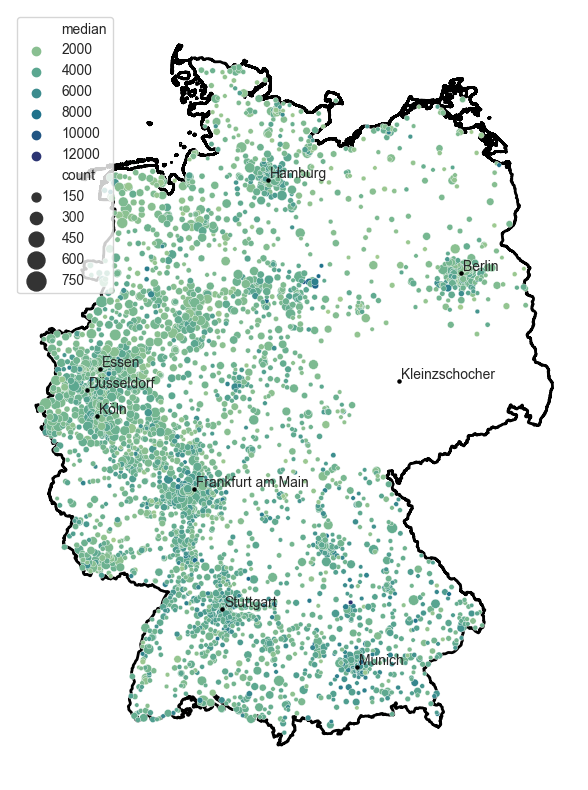

In [720]:
germany = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/1_deutschland/1_sehr_hoch.geo.json')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
germany.plot(ax=ax, color='white', edgecolor='k', linewidth=2)

sns.scatterplot(data=tmp,
                y='latitude',
                x='longitude',
                hue='median',
                palette='crest',
                size='count',
                sizes=(10, 200), ax=ax);

ax.scatter(top_cities['longitude'].head(9), top_cities['latitude'].head(9), c='k', s=5)
for row in top_cities.head(9).iterrows():
    ax.annotate(text=row[1]['Name'],
                xy=(row[1]['longitude'], row[1]['latitude']),
                xytext=(1.5, 1.5),
                textcoords='offset points')

ax.axis('off')
ax.legend(loc='upper left')
ax.grid(False);

По какой-то причине не распознались почтовые индексы на востоке Германии

Добавим в таблицу население городов, но прежде проверим, население скольких городов мы не знаем

In [784]:
df['place_name'].apply(lambda x: 0 if x in top_cities['Name'].values else 1).sum()

KeyboardInterrupt: 

Почти треть. Можно было бы добавить население ближайшего по координатам города, но функция будет слишком долго работать

In [ ]:
df = pd.merge(df, top_cities.set_index('Name')['Population'], left_on='place_name', right_index=True, how='left')

In [ ]:
df = df.rename({'Population': 'population'}, axis=1)

In [ ]:
print(f'Координаты неизвестны для {df["latitude"].isna().sum()/df["latitude"].shape[0]:.1%} записей')
print(f'Население неизвестно для {df["population"].isna().sum()/df["population"].shape[0]:.1%} записей')

Добавить координаты и плотность населения не удалось для большого числа записей, пропуски нужно чем-то заполнить. Первое, что приходит в голову, это заполнить средним/медианой, но судя по карте, пропуски имеют закономерность - большинство из них расположены на востоке Германии, а заполнение средним наоборот поместит их на запад. Но проект учебный, так что ничего страшного

Названия населенных пунктов и регионов слишком увеличат размерность, так что их стоит удалить

In [ ]:
df = df.drop(['place_name', 'state_name'], axis=1)

## date_crawled

In [879]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])

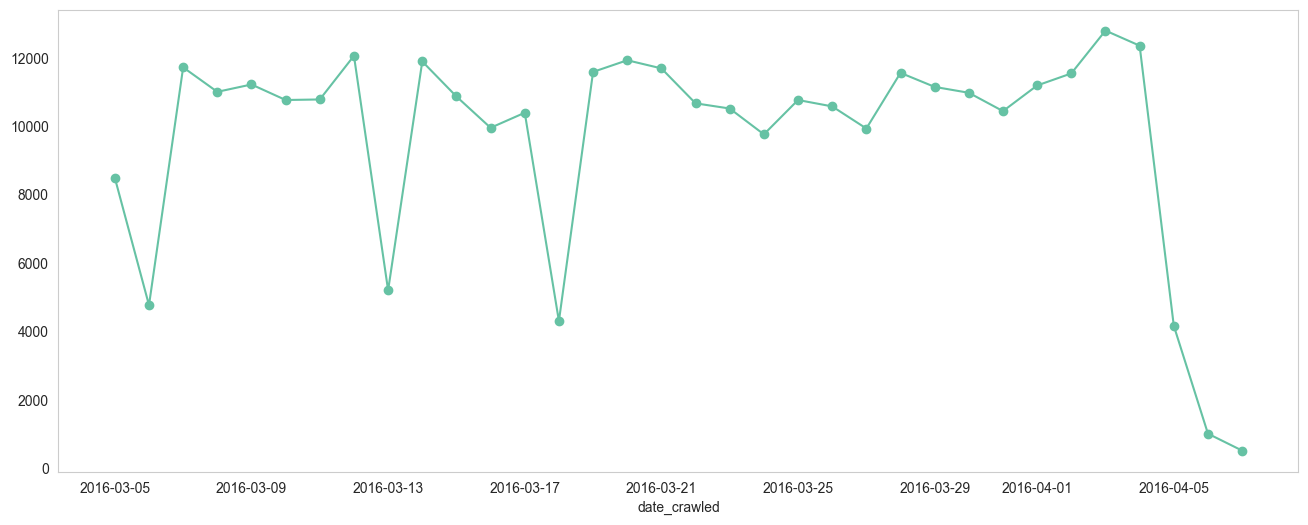

In [786]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df['date_crawled'].dt.date.value_counts().plot(grid=False, marker='o', color='#66c2a4', ax=ax);

## brand

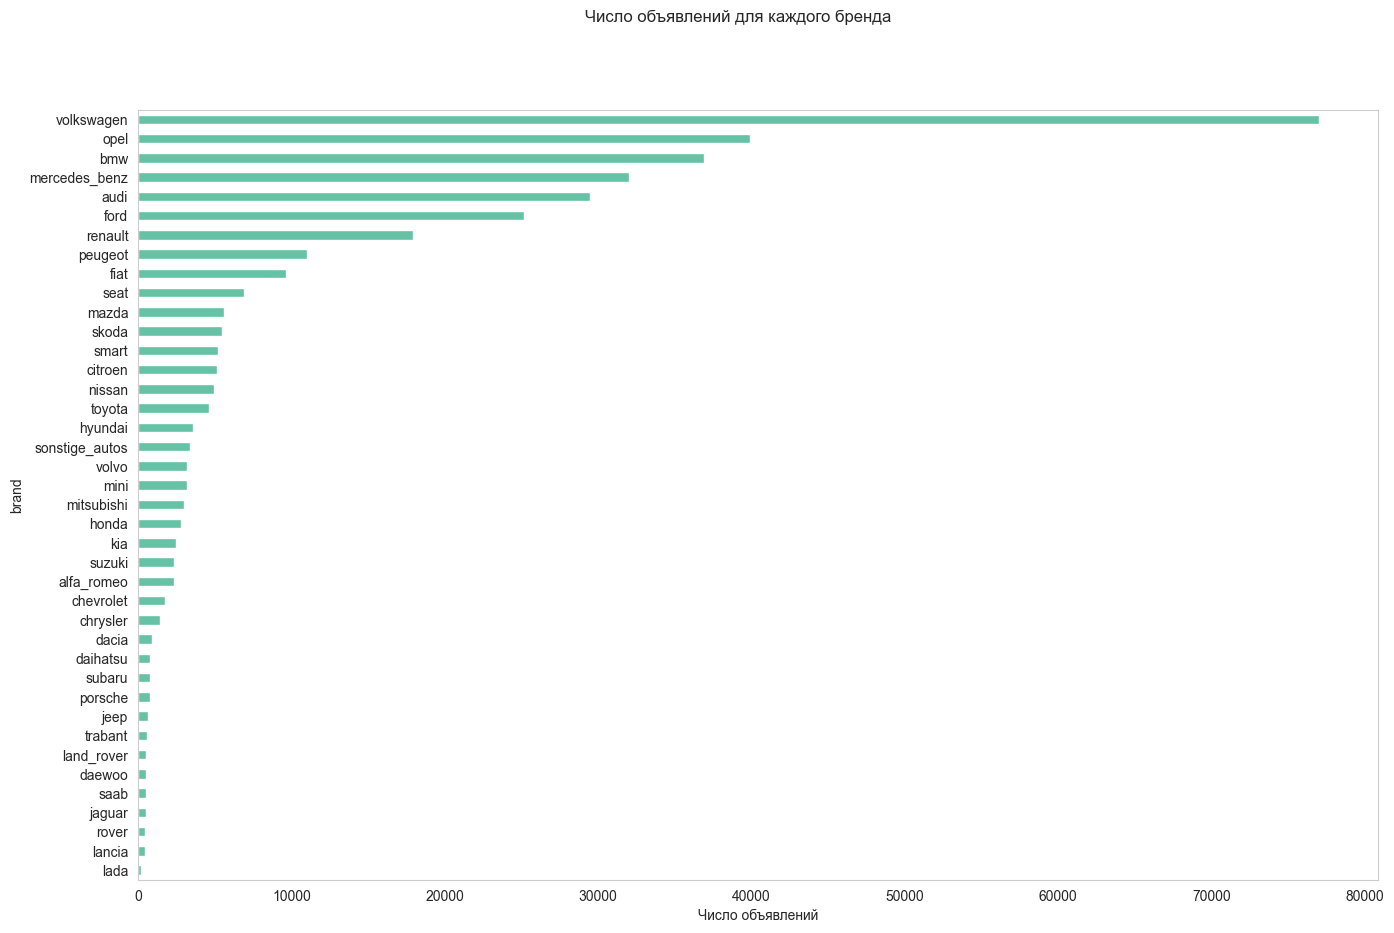

In [870]:
df['brand'].value_counts()[::-1].plot.barh(figsize=(16, 10), color='#66c2a4',grid=False);
plt.suptitle('Число объявлений для каждого бренда')
plt.xlabel('Число объявлений');

Много брендов встречаются всего в нескольких сотнях объявлений

## vehicle_type

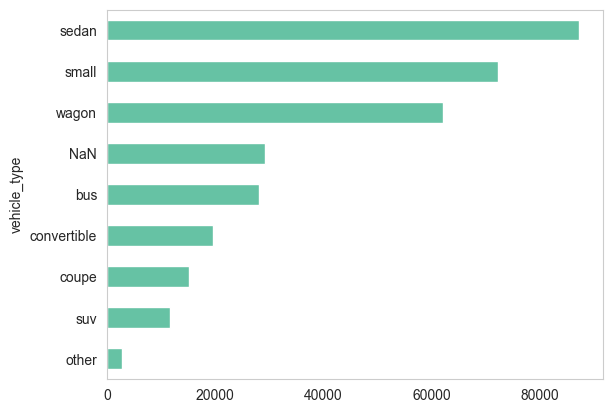

In [788]:
df['vehicle_type'].fillna('NaN').value_counts()[::-1].plot.barh(color='#66c2a4', grid=False);

Почти 40000 тысяч пропусков. Заполним их категорией 'other'

In [789]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

## model

У разных брендов модели могут называться одинаково. Проверим это

In [790]:
df.groupby('model')['brand'].nunique().sort_values().tail(10)

model
corsa          1
3_reihe        2
matiz          2
5_reihe        2
1_reihe        2
defender       2
freelander     2
discovery      2
grand          3
other         39
Name: brand, dtype: int64

Надеемся, третий рейх это безобидное обозначение поколения автомобиля

Посмотрим, под какими брендами выпускается Дефендер

In [791]:
df[df['model']=='defender']['brand'].unique()

array(['land_rover', 'rover'], dtype=object)

Кажется, это один бренд, объединим такие записи

In [792]:
df.loc[:, 'brand'] = df['brand'].replace({'rover': 'land_rover'})

Много моделей не опознано. Заменим их на other

In [873]:
df.loc[:, 'model'] = df['model'].fillna('other')

Анализ показал, что у разных брендов модели могут называться одинаково, поэтому добавим в поле с моделью имя бренда

In [874]:
df.loc[:, 'model'] = df.apply(lambda x: ' '.join([x['brand'], x['model']]), axis=1)

In [875]:
df['model'].sample(3)

231353                   audi a4
270120                   bmw 3er
76615     mercedes_benz c_klasse
Name: model, dtype: object

## registration_year

In [741]:
df['registration_year'].round(-2).value_counts()

registration_year
2000     328288
1900         88
1000         22
10000        12
5000          9
6000          5
1800          4
1600          3
7000          3
4500          2
3000          2
5600          2
2500          2
5900          2
4000          2
9000          2
1200          2
1500          2
2900          1
4100          1
1300          1
7100          1
7800          1
3200          1
2800          1
8900          1
1100          1
2100          1
1400          1
9400          1
2300          1
4800          1
3800          1
3700          1
8500          1
5300          1
8200          1
Name: count, dtype: int64

в 2000-ые или хотя бы в 1900-ые было выпущено большинство машин. Тем не менее, достаточно много машин имеют неадекватный год выпуска. Заменим его на медианный для комбинации марка-модель

Убедимся, что наше предположение о невысокой дисперсии года выпуска для сочетания марка-модель верно. Возьмем только машины, выпущенные в адекватные 1920-2019 годы и те, для которых указана модель. Поверим, что кто-то продает столетний раритет

In [812]:
lifecycle = df[(df['registration_year'].between(1920, 2019)) & ~df['model'].str.contains('other')]

In [814]:
lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False)

,count,std
model,,
land_rover serie_2,8,18.493242
ford mustang,162,17.062383
fiat 500,893,12.916056
porsche 911,64,12.476794
volkswagen kaefer,396,11.928255
...,...,...
ford b_max,26,1.022817
mercedes_benz gl,12,0.717741
daihatsu materia,18,0.685994


В основном в таблицу попали не очень массово выпускавшиеся/раритетные машины. Посмотрим на годы жизни этих линеек и следом сравним с машинами, которые выпускались не так долго

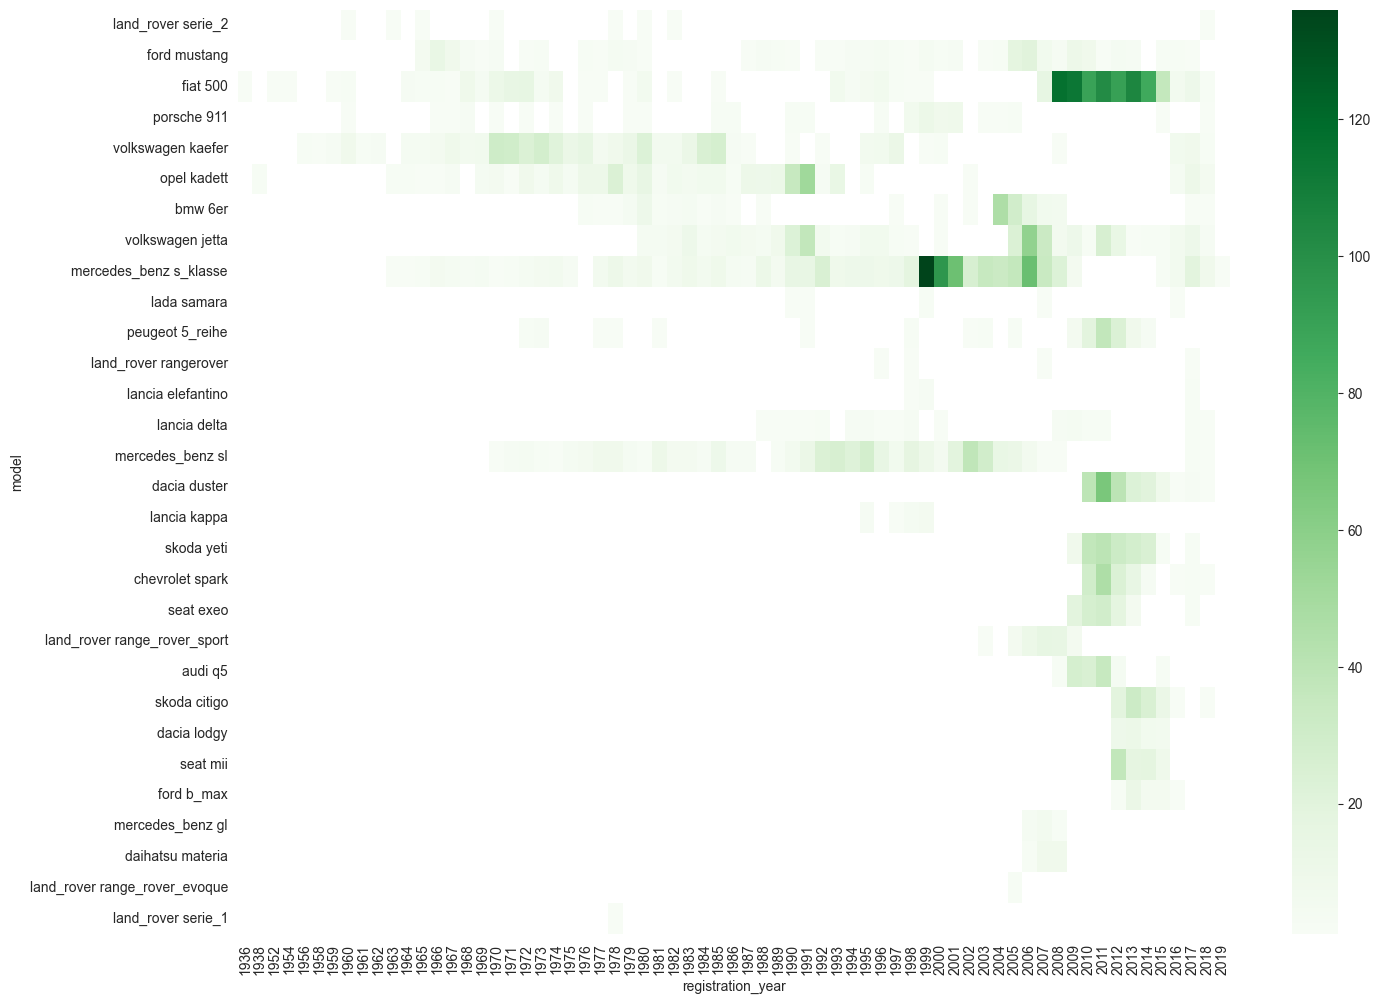

In [817]:
top_models = lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False).index[:15].to_list() + lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False).index[-15:].to_list()


fig, ax = plt.subplots(1, 1, figsize=(16, 12))
sns.heatmap(lifecycle[lifecycle['model'].isin(top_models)].pivot_table(values='price', index='model', columns='registration_year', aggfunc='count').reindex(top_models),
            cmap='Greens');
ax.grid(False)

В верхней половине графика модели с высокой дисперсией, в нижней - с низкой. Теперь посмотрим на дисперсию года выпуска массово выпускавшихся машин

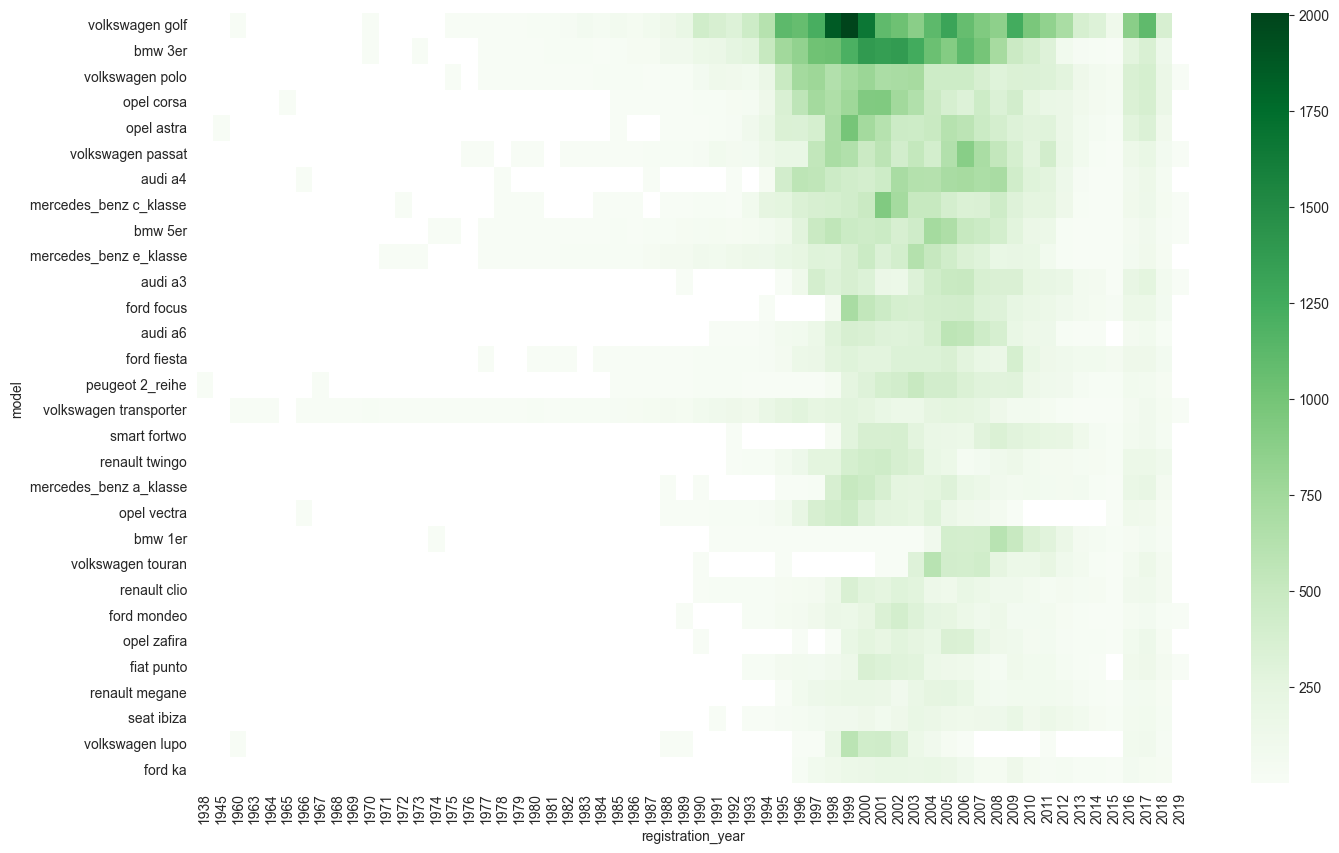

In [818]:
top_models = lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='count', ascending=False).index[:30].to_list()


fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.heatmap(lifecycle[lifecycle['model'].isin(top_models)].pivot_table(values='price', index='model', columns='registration_year', aggfunc='count').reindex(top_models),
            cmap='Greens');
ax.grid(False)

Из двух графиков следует, что некоторые машины, такие как Фольксваген Транспортер стабильно равными партиями выпускаются в течение несколкьих десятков лет, другие становились популярны не сразу или переживали серьезную доработку (Фиат 500). К производству третьих компании впоследствии возвращались (Фольксваген Джетта). С другой стороны, в нашем распоряжении всего лишь выборка машин с сайта по их продаже, и пробелы на жизненном цикле линейки говорят лишь об отсутствии таких машин в продаже на данном сайте. В любом случае, делаем вывод о возможности замены года выпуска медианой (из-за скошенности данных). Но лишь в процессе кросс-валидации.

В данных много выбросов, заменим их на наны. За правую границу возьмем текущий год, но позже сравним год выпуска с имеющимися датами

In [825]:
df.loc[~df['registration_year'].between(1920, 2023), 'registration_year'] = np.nan

## gearbox

In [746]:
df['gearbox'].value_counts(dropna=False)

gearbox
manual    249993
auto       64056
NaN        14422
Name: count, dtype: int64

Заменим большинством

In [819]:
df['gearbox'].fillna('manual', inplace=True)

## power

У признака много выбросов.

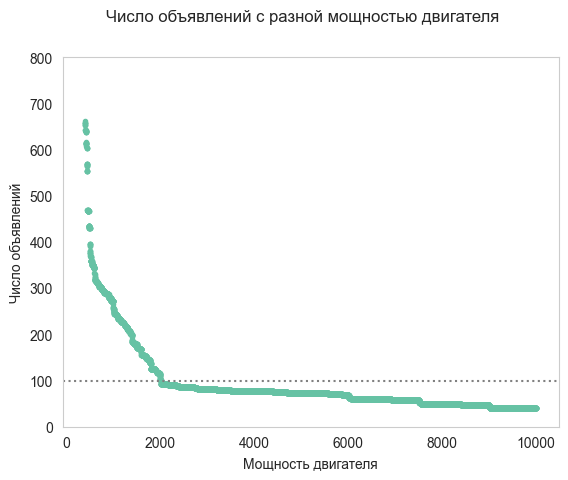

In [747]:
for thr in range(400, 10000):
    plt.plot(thr, df[df['power']>thr].shape[0], marker='.', color='#66c2a4')
    plt.grid(False)
plt.suptitle('Число объявлений с разной мощностью двигателя')
plt.ylim([0, 800])
plt.axhline(100, linestyle=':', color='grey');
plt.xlabel('Мощность двигателя')
plt.ylabel('Число объявлений');

Интересная неинтерпретируемая зависимость - объявления начинают слабее убывать примерно на отметке 2000 лс. Хотя и этот предел неадекватен мощности двигателя, можно предположить, что какие-то значения все же записаны в неправильных единицах измерения

Заменим все выбросы на Наны. Пусть адекватной мощностью двигателя будет диапазон 20...600 л.с

In [830]:
df.loc[~df['power'].between(20, 600), 'power'] = np.nan

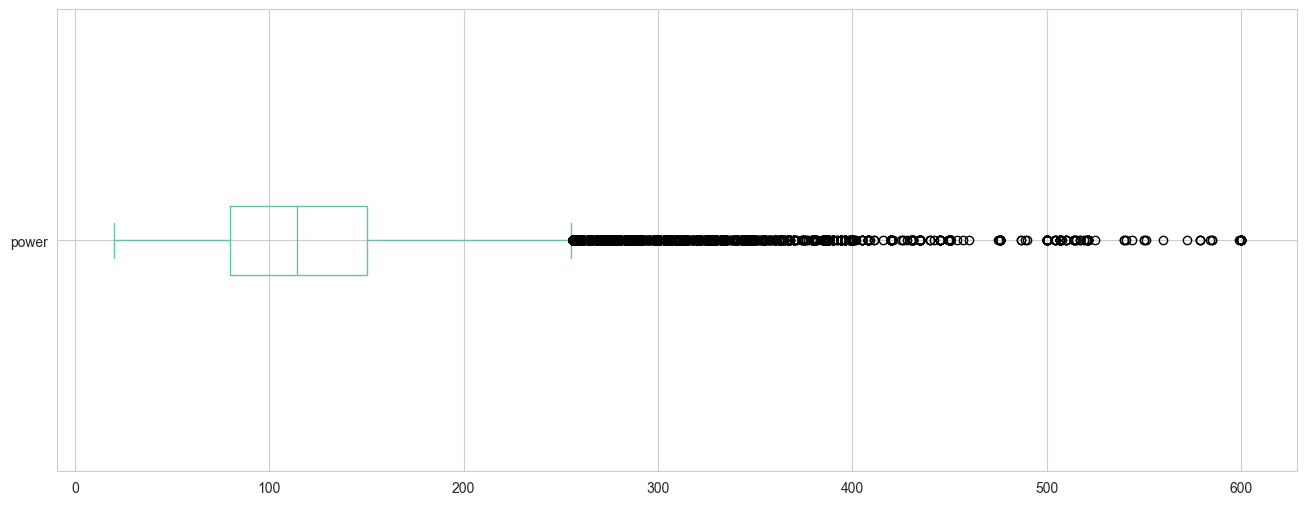

In [831]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df['power'].plot.box(grid=True, vert=False, color='#66c2a4', ax=ax);

## kilometer

In [749]:
df['kilometer'].value_counts()

kilometer
150000    219042
125000     34788
100000     13993
90000      11175
80000       9753
70000       8376
60000       7303
50000       6086
40000       4815
30000       4240
5000        4189
20000       3652
10000       1059
Name: count, dtype: int64

Значения дискретны, и значение 150000 несет смысл "более 150 тыс км". закодируем их через OrdinalEncoder.

## registration_month

In [843]:
df['registration_month'].value_counts()

registration_month
0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: count, dtype: int64

Месяцев получилось тринадцать! Наверное, значение 0 можно интерпретировать как "неизвестно", тем более его значение немного превышает все остальные. Сам по себе месяц выпуска/регистрации машины не должен ни с чем коррелировать, но вот информация о том, известен ли месяц, может означать наличие нормальных документов на машину. Попробуем закодировать этот признак бинарно

In [851]:
df['registration_month'] = df['registration_month']>0

## fuel_type

In [850]:
df['fuel_type'].value_counts()

fuel_type
petrol      216349
gasoline     98719
other         6402
Name: count, dtype: int64

В списке отсутствует дизель, но понадеемся, что он скрывается за одним из терминов gasoline/petrol, потому что если переводить дословно, то оба они - бензин. А вот маленькие категории объединим в other

In [849]:
df.loc[df['fuel_type'].isin(['lpg', 'cng', 'hybrid', 'electric']), 'fuel_type'] = 'other'

In [753]:
df['not_repaired'].value_counts(dropna=False)

not_repaired
no     240479
NaN     58821
yes     29171
Name: count, dtype: int64

Отнесем наны к неремонтированным машинам

In [754]:
df['not_repaired'] = df['not_repaired'].fillna('yes')

In [755]:
df['not_repaired'] = df['not_repaired'].replace({'yes': 1, 'no': 0}).astype('bool')

## date_created и last_seen

Переведем колонки в тип даты

In [880]:
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

В датасете несколько столбцов с датами, давайте проверим, все ли даты правильно упорядочены во времени

In [883]:
df[~((df['registration_year']<=df['date_created'].dt.year) &
   (df['date_created'].dt.year<=df['last_seen'].dt.year) &
   (df['last_seen'].dt.year<=df['date_crawled'].dt.year))]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,place_name,state_name,latitude,longitude
22,2016-03-23 14:52:51,2900,NaN,NaN,manual,90,opel meriva,150000,True,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,Meppen,Niedersachsen,52.690600,7.291000
26,2016-03-10 19:38:18,5555,NaN,NaN,manual,125,citroen c4,125000,True,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,Hildesheim,Niedersachsen,52.141000,9.940700
48,2016-03-25 14:40:12,7750,NaN,NaN,manual,80,volkswagen golf,100000,True,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44,Salzbergen,Niedersachsen,52.325600,7.430500
51,2016-03-07 18:57:08,2000,NaN,NaN,manual,90,fiat punto,150000,True,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08,Saarbrücken,Saarland,49.239900,6.969600
57,2016-03-10 20:53:19,2399,NaN,NaN,manual,64,seat other,125000,True,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37,Rietberg,Nordrhein-Westfalen,51.809200,8.428400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,NaN,manual,86,ford transit,150000,True,gasoline,ford,NaN,2016-03-11,0,32339,2016-03-12 05:45:02,Espelkamp,Nordrhein-Westfalen,52.382500,8.621300
354140,2016-03-29 16:47:29,1000,NaN,NaN,manual,101,audi a4,150000,True,NaN,audi,NaN,2016-03-29,0,38315,2016-04-06 02:44:27,"Gielde, Schladen, Hornburg, Werlaburgdorf",Niedersachsen,52.034850,10.543900
354203,2016-03-17 00:56:26,2140,NaN,NaN,manual,80,ford fiesta,150000,True,NaN,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04,Bochum,Nordrhein-Westfalen,51.480800,7.148600
354253,2016-03-25 09:37:59,1250,NaN,NaN,NaN,0,opel corsa,150000,False,petrol,opel,NaN,2016-03-25,0,45527,2016-04-06 07:46:13,Hattingen,Nordrhein-Westfalen,51.400000,7.166700


Почти 15 тыс объявлений не упорядочены. Без лишних выкладок скажем, что во всех них дата регистрации позже даты создания объявления, последнего посещения и его скачивания. Заменим в таких объявлениях год регистрации на nan

In [882]:
df.loc[~((df['registration_year']<=df['date_created'].dt.year) &
   (df['date_created'].dt.year<=df['last_seen'].dt.year) &
   (df['last_seen'].dt.year<=df['date_crawled'].dt.year)), 'registration_year'] = np.nan

Наконец, удалим вспомогательные столбцы

In [760]:
# df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,latitude,longitude,population
0,480,other,1993,manual,0,volkswagen volkswagen golf,150000,petrol,volkswagen,True,48.800050,9.174450,NaN
1,18300,coupe,2011,manual,190,audi audi other,125000,gasoline,audi,True,49.207100,7.591100,43582.0
2,9800,suv,2004,auto,163,jeep jeep grand,125000,gasoline,jeep,True,49.437100,11.119400,515543.0
3,1500,small,2001,manual,75,volkswagen volkswagen golf,150000,petrol,volkswagen,False,49.568000,10.885600,23319.0
4,3600,small,2008,manual,69,skoda skoda fabia,90000,gasoline,skoda,False,50.192400,8.675300,650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,opel opel zafira,150000,petrol,opel,False,53.475527,7.351636,NaN
354365,2200,other,2005,NaN,0,sonstige_autos sonstige_autos other,20000,NaN,sonstige_autos,True,52.606900,11.858700,37722.0
354366,1199,convertible,2000,auto,101,smart smart fortwo,125000,petrol,smart,False,53.126700,8.238400,159218.0
354367,9200,bus,1996,manual,102,volkswagen volkswagen transporter,150000,gasoline,volkswagen,False,47.717700,10.298900,NaN


Посмотрим на корреляции оставшихся признаков. Категориальные признаки для этого нужно закодировать через LabelEncoder/OrdinalEncoder

# Разделение на обучающую и тестовую выборки

In [761]:
x = df.drop('price', axis=1)
y = df['price']

In [762]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# Создание кастомной метрики

In [763]:
def rmse(y_true, y_pred):
    return -1*(mean_squared_error(y_true, y_pred, squared=False))
rmse_score = make_scorer(rmse, greater_is_better=False)

# Обучение моделей

Посмотрим еще раз отдельно на числовые и категориальные признаки

In [764]:
x.select_dtypes(exclude='object').describe()

,registration_year,power,kilometer,latitude,longitude,population
count,328471.000000,328471.000000,328471.000000,312487.000000,312487.000000,2.367610e+05
mean,2004.047581,113.411641,128301.326449,50.887695,9.256463,3.159433e+05
std,67.524206,187.234787,37160.167991,1.741929,1.966610,7.834323e+05
min,1000.000000,0.000000,5000.000000,47.407200,5.963900,0.000000e+00
25%,1999.000000,75.000000,125000.000000,49.443300,7.634200,1.420000e+04
50%,2003.000000,105.000000,150000.000000,51.000600,8.854900,4.392000e+04
75%,2008.000000,143.000000,150000.000000,52.273800,10.468700,2.122070e+05
max,9999.000000,20000.000000,150000.000000,55.019200,14.639174,3.426354e+06


In [765]:
x.select_dtypes(include='object').nunique().to_frame()

,0
vehicle_type,8
gearbox,2
model,294
fuel_type,7
brand,39


Так как мы почти ничего не удаляли, у нас много выбросов в обеих группах данных.

In [766]:
x_train['kilometer'] = OrdinalEncoder().fit_transform(x_train['kilometer'].values.reshape(-1, 1))
x_train['model'] = OrdinalEncoder().fit_transform(x_train['model'].values.reshape(-1, 1))

In [767]:
x_train.isna().sum()

vehicle_type             0
registration_year        0
gearbox              11628
power                    0
model                    0
kilometer                0
fuel_type            20314
brand                    0
not_repaired             0
latitude             12819
longitude            12819
population           73375
dtype: int64

In [768]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262776 entries, 116906 to 269076
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       262776 non-null  object 
 1   registration_year  262776 non-null  int64  
 2   gearbox            251148 non-null  object 
 3   power              262776 non-null  int64  
 4   model              262776 non-null  float64
 5   kilometer          262776 non-null  float64
 6   fuel_type          242462 non-null  object 
 7   brand              262776 non-null  object 
 8   not_repaired       262776 non-null  bool   
 9   latitude           249957 non-null  float64
 10  longitude          249957 non-null  float64
 11  population         189401 non-null  float64
dtypes: bool(1), float64(5), int64(2), object(4)
memory usage: 24.3+ MB


In [769]:
num_ct_robust = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', RobustScaler(quantile_range=(15, 85)))])

num_ct_standard = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

# num_ct_ordinal = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
#                                  ('ordinal', OrdinalEncoder()),
#                                  ('scaler', StandardScaler())
#                                  ])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums_robust', num_ct_robust, ('registration_year', 'power',)),
                                              ('nums_standard', num_ct_standard, ('kilometer', 'latitude', 'longitude', 'population', 'model', )),
                                              # ('nums_ordinal', num_ct_ordinal, ('kilometer')),
                                              ('cats', cat_ct, selector(dtype_include='object'))],
                                remainder='passthrough')

lr_pipe = Pipeline([('transformer', transformer), ('estimator', LinearRegression())])

In [770]:
cross_val_score(lr_pipe, x_train, y_train, scoring=rmse_score, cv=3, n_jobs=-1, error_score='raise').mean()

3388.5753392854044

In [771]:
x['kilometer']

0         150000
1         125000
2         125000
3         150000
4          90000
           ...  
354363    150000
354365     20000
354366    125000
354367    150000
354368    150000
Name: kilometer, Length: 328471, dtype: int64

In [772]:
num_ct_ordinal.fit_transform(x['kilometer'].values.reshape(-1, 1))[:15]

array([[ 0.50695941],
       [ 0.12740428],
       [ 0.12740428],
       [ 0.50695941],
       [-0.63170599],
       [ 0.50695941],
       [ 0.50695941],
       [-2.9090368 ],
       [ 0.50695941],
       [ 0.50695941],
       [ 0.50695941],
       [ 0.50695941],
       [ 0.50695941],
       [-1.39081626],
       [-4.04770221]])

In [773]:
x['kilometer'].values.reshape(-1, 1)[:15]

array([[150000],
       [125000],
       [125000],
       [150000],
       [ 90000],
       [150000],
       [150000],
       [ 30000],
       [150000],
       [150000],
       [150000],
       [150000],
       [150000],
       [ 70000],
       [  5000]], dtype=int64)

In [774]:
transformer.fit_transform(x_train)

<262776x60 sparse matrix of type '<class 'numpy.float64'>'
	with 2836040 stored elements in Compressed Sparse Row format>